In [1]:
import os
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from scipy.stats import f_oneway
from scipy.stats import chi2_contingency

C:\Users\DilanF\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 10000)

# Loading training data from the CSV

In [3]:
# Specify dtype for column 'Monthly_Balance' as a string (Column 'Monthly_Balance' has mixed data types)
dtypes = {'Monthly_Balance': str}
train_df = pd.read_csv('train.csv', dtype = dtypes)

# Data Preparation - Step 1

#### This data set has many columns and need to remove all personally Identifiable Data

In [4]:
train_df.columns

Index(['ID', 'Customer_ID', 'Month', 'Name', 'Age', 'SSN', 'Occupation',
       'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Type_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance',
       'Credit_Score'],
      dtype='object')

#### The ID, Customer_ID, Name, and SSN columns are extremely useful in identifying a specific customer (PII data). So, such columns will be removed from our trainigi data set. Furthermore, there is a column called 'Month' that does not give much weight to our classification. As a result, those columns will be excluded too.

#### The Num_Credit_Inquiries data is also ambiguous. It doesn't mean clearly the query count is generated from bank to customer or customer to bank. We believe it will not add value to the credit score we intend to establish. As such, that column will be excluded as well.  

In [5]:
#Remove sensitive data columns
train_df1 = train_df.drop(['ID', 'Customer_ID', 'Name', 'SSN', 'Month', 'Num_Credit_Inquiries'], axis=1)
train_df1.shape

(100000, 22)

# Data Cleanup

In [6]:
train_df1 = train_df1.applymap(
  lambda x: x if x is np.NaN or not \
    isinstance(x, str) else str(x).strip('_')).replace(['', 'nan', '!@9#%8', '#F%$D@*&8'], np.NaN)
train_df1.shape

(100000, 22)

In [7]:
train_df1.dtypes

Age                          object
Occupation                   object
Annual_Income                object
Monthly_Inhand_Salary       float64
Num_Bank_Accounts             int64
Num_Credit_Card               int64
Interest_Rate                 int64
Num_of_Loan                  object
Type_of_Loan                 object
Delay_from_due_date           int64
Num_of_Delayed_Payment       object
Changed_Credit_Limit         object
Credit_Mix                   object
Outstanding_Debt             object
Credit_Utilization_Ratio    float64
Credit_History_Age           object
Payment_of_Min_Amount        object
Total_EMI_per_month         float64
Amount_invested_monthly      object
Payment_Behaviour            object
Monthly_Balance              object
Credit_Score                 object
dtype: object

# Data Preparation - Step 2 

#### Some columns shouldn't be an Object type as it has all numeric values. Let's convert those columns to a Numeric Type

In [8]:
train_df1['Age'] = pd.to_numeric(train_df1['Age'], errors='coerce').astype('int64')
train_df1['Annual_Income'] = pd.to_numeric(train_df1['Annual_Income'], errors='coerce').astype('float')
train_df1['Num_of_Loan'] = pd.to_numeric(train_df1['Num_of_Loan'], errors='coerce').astype('int32')
train_df1['Changed_Credit_Limit'] = pd.to_numeric(train_df1['Changed_Credit_Limit'], errors='coerce').astype('float')
train_df1['Outstanding_Debt'] = pd.to_numeric(train_df1['Outstanding_Debt'], errors='coerce').astype('float')
train_df1['Amount_invested_monthly'] = pd.to_numeric(train_df1['Amount_invested_monthly'], errors='coerce').astype('float')
train_df1['Monthly_Balance'] = pd.to_numeric(train_df1['Monthly_Balance'], errors='coerce').astype('float')
train_df1['Num_of_Delayed_Payment'] = pd.to_numeric(train_df1['Num_of_Delayed_Payment'], errors='coerce').astype('float')


In [9]:
train_df1.dtypes

Age                           int64
Occupation                   object
Annual_Income               float64
Monthly_Inhand_Salary       float64
Num_Bank_Accounts             int64
Num_Credit_Card               int64
Interest_Rate                 int64
Num_of_Loan                   int32
Type_of_Loan                 object
Delay_from_due_date           int64
Num_of_Delayed_Payment      float64
Changed_Credit_Limit        float64
Credit_Mix                   object
Outstanding_Debt            float64
Credit_Utilization_Ratio    float64
Credit_History_Age           object
Payment_of_Min_Amount        object
Total_EMI_per_month         float64
Amount_invested_monthly     float64
Payment_Behaviour            object
Monthly_Balance             float64
Credit_Score                 object
dtype: object

## Missing Values 

In [10]:
# Calculate the sum of missing values in each column
missing_values_sum = train_df1.isna().sum()

# Calculate the percentage of missing values for each column
total_rows = train_df1.shape[0]
missing_values_percentage = (missing_values_sum / total_rows) * 100

# Get the data type of the column as well
column_datatypes = train_df1.dtypes

# Create a DataFrame to display the results
missing_info = pd.DataFrame({
    'Data Type': column_datatypes,
    'Missing Values': missing_values_sum,
    'Percentage Missing (%)': missing_values_percentage
})

# Display the missing values sum and percentage
print(missing_info)

                         Data Type  Missing Values  Percentage Missing (%)
Age                          int64               0                   0.000
Occupation                  object            7062                   7.062
Annual_Income              float64               0                   0.000
Monthly_Inhand_Salary      float64           15002                  15.002
Num_Bank_Accounts            int64               0                   0.000
Num_Credit_Card              int64               0                   0.000
Interest_Rate                int64               0                   0.000
Num_of_Loan                  int32               0                   0.000
Type_of_Loan                object           11408                  11.408
Delay_from_due_date          int64               0                   0.000
Num_of_Delayed_Payment     float64            7002                   7.002
Changed_Credit_Limit       float64            2091                   2.091
Credit_Mix               

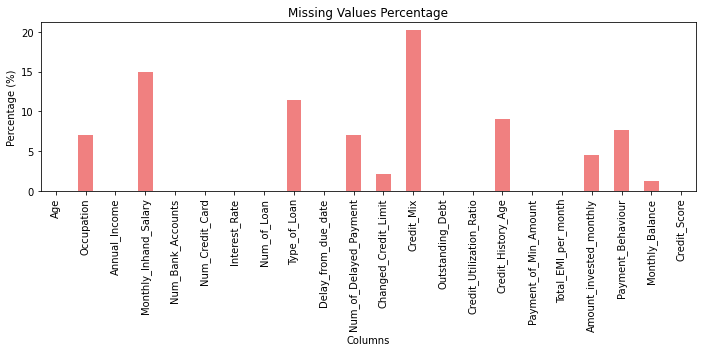

In [11]:
# Create a bar plot for missing values percentage 
plt.figure(figsize=(10, 5))

missing_values_percentage.plot(kind='bar', color='lightcoral')
plt.title('Missing Values Percentage')
plt.xlabel('Columns')
plt.ylabel('Percentage (%)')

# Adjust spacing between plots
plt.tight_layout()

# Show the plot
plt.show()

#### Occupation (7%), Monthly_Inhand_Salary (15%), Type_of_Loan (11%), Num_of_Delayed_Payment (7%), Changed_Credit_Limit (2%),  Credit_Mix (20%), Credit_History_Age (9%), Amount_invested_monthly (4%), Payment_Behaviour (7%) & Monthly_Balance (1%) are having missing values. 

# Missing Value Handling Stratergy:  

###  1. most_frequent strategy will use for Occupation, Monthly_Inhand_Salary, Type_of_Loan, Credit_Mix, Payment_Behaviour

### 2. Remove rows for the other colums with missing values

In [12]:
# Replace missing values using most_frequent strategy
imputer = SimpleImputer(strategy='most_frequent')
train_df1[['Occupation', 'Type_of_Loan', 'Credit_Mix', 'Payment_Behaviour']] = imputer.fit_transform(train_df1[['Occupation', 'Type_of_Loan', 'Credit_Mix', 'Payment_Behaviour']])


In [13]:
# Remove rows with missing values
train_df1 = train_df1.dropna(axis=0)

In [14]:
# Calculate the sum of missing values in each column
missing_values_sum = train_df1.isna().sum()

# Calculate the percentage of missing values for each column
total_rows = train_df1.shape[0]
missing_values_percentage = (missing_values_sum / total_rows) * 100

# Get the data type of the column as well
column_datatypes = train_df1.dtypes

# Create a DataFrame to display the results
missing_info = pd.DataFrame({
    'Data Type': column_datatypes,
    'Missing Values': missing_values_sum,
    'Percentage Missing (%)': missing_values_percentage
})

# Display the missing values sum and percentage
print(missing_info)

                         Data Type  Missing Values  Percentage Missing (%)
Age                          int64               0                     0.0
Occupation                  object               0                     0.0
Annual_Income              float64               0                     0.0
Monthly_Inhand_Salary      float64               0                     0.0
Num_Bank_Accounts            int64               0                     0.0
Num_Credit_Card              int64               0                     0.0
Interest_Rate                int64               0                     0.0
Num_of_Loan                  int32               0                     0.0
Type_of_Loan                object               0                     0.0
Delay_from_due_date          int64               0                     0.0
Num_of_Delayed_Payment     float64               0                     0.0
Changed_Credit_Limit       float64               0                     0.0
Credit_Mix               

In [15]:
train_df1.shape

(66461, 22)

# Remove Outliers  

In [16]:
# Define a function to generate a box plot for a specific column
def generate_boxplot(data, column_name):
    plt.figure(figsize=(8, 6))
    sns.boxplot(y=data[column_name])
    
    # Customize the y-axis tick labels
    plt.gca().get_yaxis().get_major_formatter().set_scientific(False)
    
    plt.ylabel(column_name)
    plt.title(f'Box Plot of {column_name}')
    plt.show()

In [17]:
# Define a function to generate a histogram for a specific column
def generate_histogram(data, column_name):
    plt.figure(figsize=(8, 6))
    sns.histplot(data[column_name], bins=20, kde=True)  # Adjust the number of bins as needed
    
    # Customize the y-axis tick labels
    plt.gca().get_yaxis().get_major_formatter().set_scientific(False)
    
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {column_name}')
    plt.show()

In [18]:
# Define a function to generate a bar chart for a specific column
def generate_bar_chart(data, column_name):
    data_counts = data[column_name].value_counts().sort_index()

    # Create a bar plot
    plt.figure(figsize=(20, 12))  # Adjust the figure size as needed
    data_counts.plot(kind='bar', rot=0)  # 'rot' parameter controls x-axis label rotation
    
    # Customize the y-axis tick labels
    plt.gca().get_yaxis().get_major_formatter().set_scientific(False)
    
    plt.xlabel(column_name)
    plt.ylabel('Count')
    plt.title(f'{column_name} Distribution')
    plt.xticks(rotation=90)
    plt.show()

## Age Column Data Analysis  

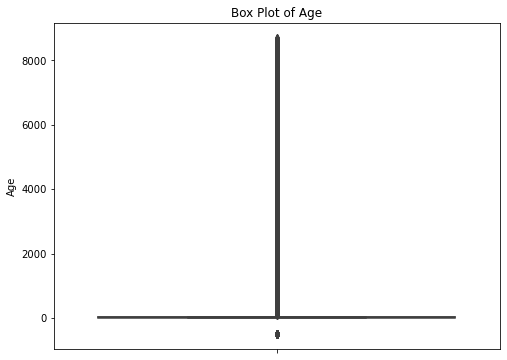

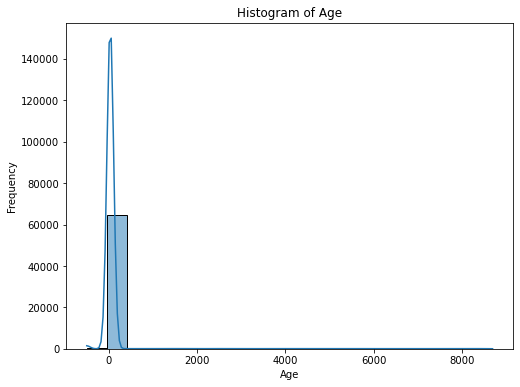

In [19]:
# Call the function to generate a box plot for the 'Age' column
generate_boxplot(train_df1, 'Age')
generate_histogram(train_df1, 'Age')
# generate_bar_chart(train_df1, 'Age')

As per the above result, the Age column contains data that doesn’t seems to be practical. We must exclude those data considering the optimal age range to be 20 to 60 years old.


In [20]:
train_df1 = train_df1[(train_df1['Age'] >= 20) & (train_df1['Age'] <= 60)]

train_df1.shape

(57275, 22)

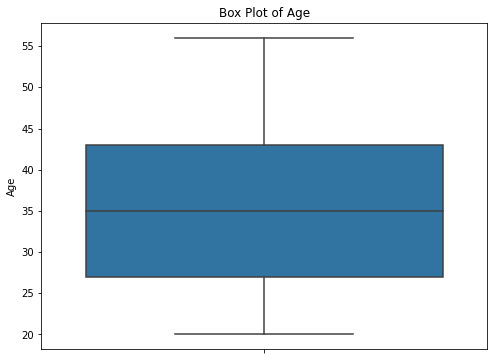

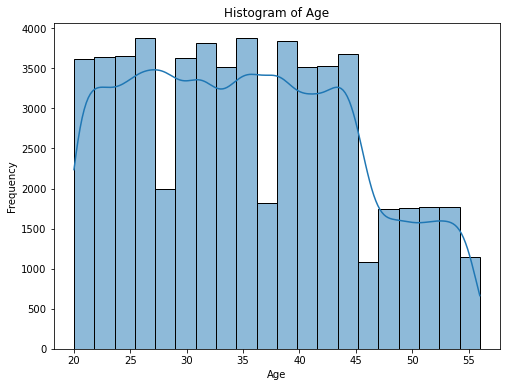

In [21]:
# Call the function to generate a box plot for the 'Age' column
generate_boxplot(train_df1, 'Age')
generate_histogram(train_df1, 'Age')
# generate_bar_chart(train_df1, 'Age')

## Annual_Income Column Data Analysis  

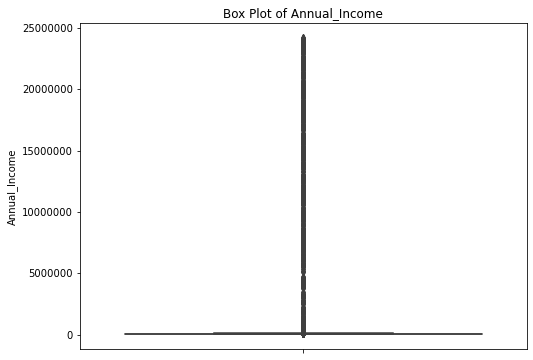

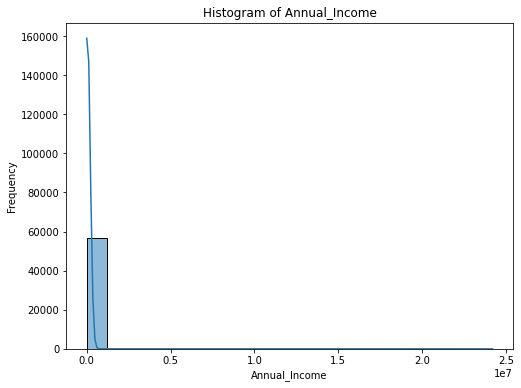

In [22]:
# Annual_Income analysis
generate_boxplot(train_df1, 'Annual_Income')
generate_histogram(train_df1, 'Annual_Income')
# generate_bar_chart(train_df1, 'Annual_Income')

According to the above diagrams the Annual_Income is having some outliers. There are some values having more than 130000 and those data will be excluded to make it more accurate. Anyway, there are no any negatives.

In [23]:
# Remove values greater that 130000
train_df1 = train_df1[(train_df1['Annual_Income'] >= 0) & (train_df1['Annual_Income'] <= 130000)]

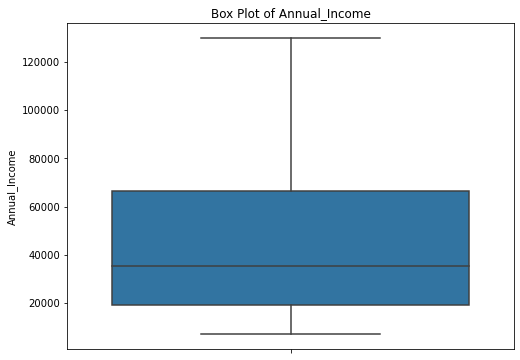

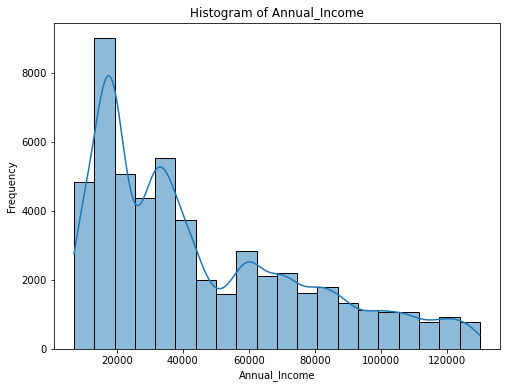

In [24]:
# Annual_Income analysis after outlier removals
generate_boxplot(train_df1, 'Annual_Income')
generate_histogram(train_df1, 'Annual_Income')
# generate_bar_chart(train_df1, 'Annual_Income')

In [25]:
train_df1.shape

(53726, 22)

## Monthly_Inhand_Salary Column Data Analysis  

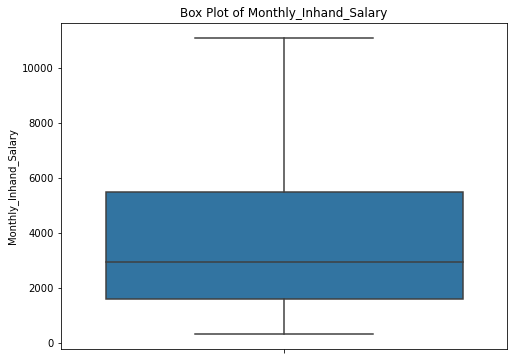

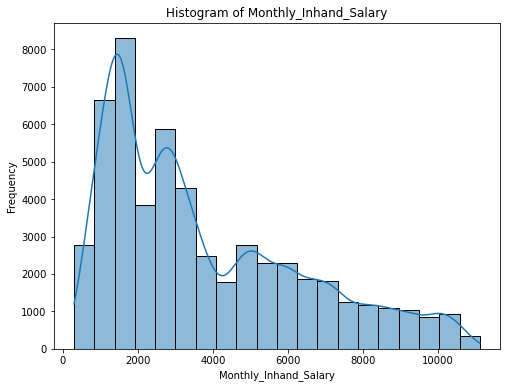

In [26]:
# Monthly_Inhand_Salary analysis
generate_boxplot(train_df1, 'Monthly_Inhand_Salary')
generate_histogram(train_df1, 'Monthly_Inhand_Salary')
# generate_bar_chart(train_df1, 'Monthly_Inhand_Salary')

As per the diagrams the Monthly_Inhand_Salary is having a practical data distribution.

## Num_Bank_Accounts Column Data Analysis  

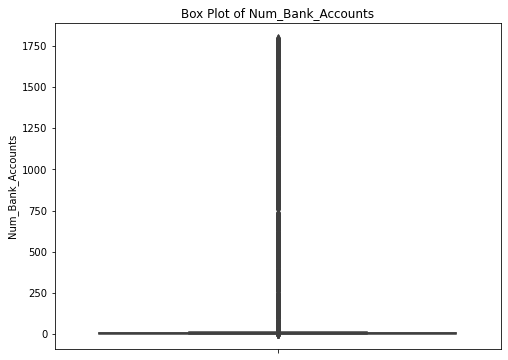

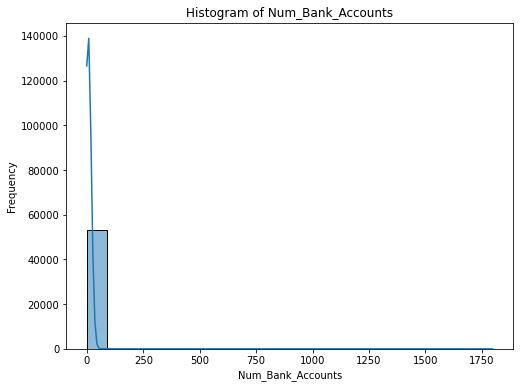

In [27]:
# Num_Bank_Accounts analysis
generate_boxplot(train_df1, 'Num_Bank_Accounts')
generate_histogram(train_df1, 'Num_Bank_Accounts')
# generate_bar_chart(train_df1, 'Num_Bank_Accounts')

The evidence presented above doesn’t seem to be accurate and the outliers should be excluded.

In [28]:
train_df1 = train_df1[(train_df1['Num_Bank_Accounts'] >= 1) & (train_df1['Num_Bank_Accounts'] <= 10)]

train_df1.shape

(50717, 22)

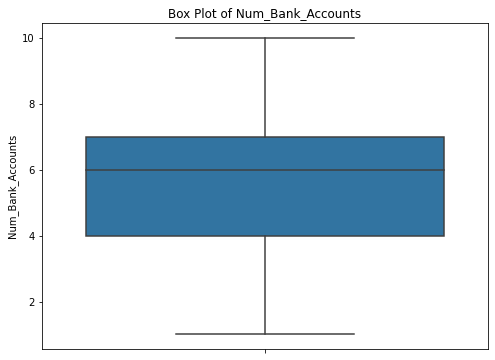

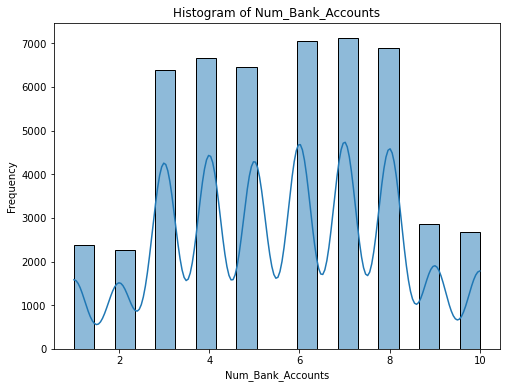

In [29]:
# Num_Bank_Accounts analysis after cleanup
generate_boxplot(train_df1, 'Num_Bank_Accounts')
generate_histogram(train_df1, 'Num_Bank_Accounts')
# generate_bar_chart(train_df1, 'Num_Bank_Accounts')

## Num_Credit_Card Column Data Analysis  

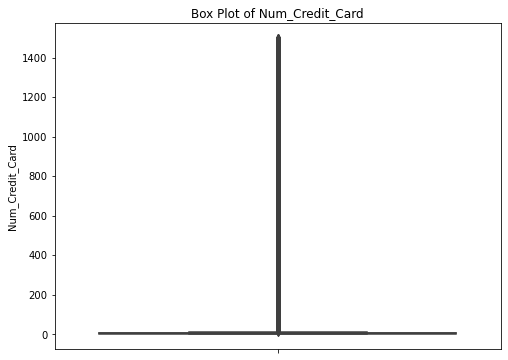

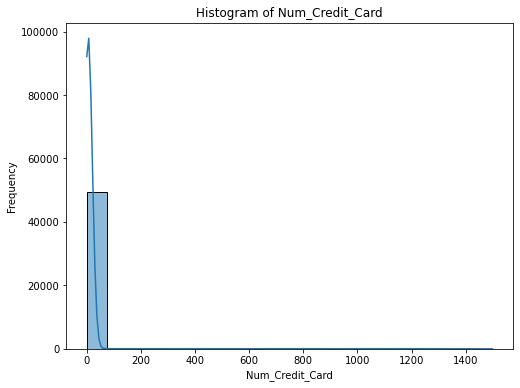

In [30]:
# Num_Credit_Card analysis
generate_boxplot(train_df1, 'Num_Credit_Card')
generate_histogram(train_df1, 'Num_Credit_Card')
# generate_bar_chart(train_df1, 'Num_Credit_Card')

According to the above visual result, it doesn’t seem to be showing accurate data. So, the outliers should be excluded.

In [31]:
train_df1 = train_df1[(train_df1['Num_Credit_Card'] >= 1) & (train_df1['Num_Credit_Card'] <= 10)]

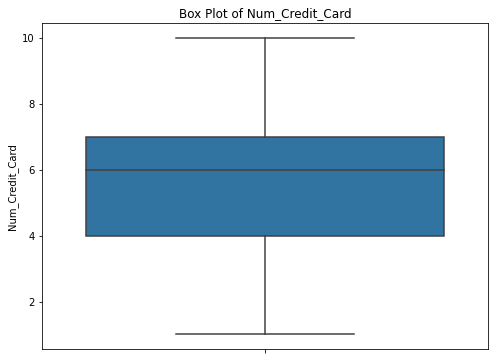

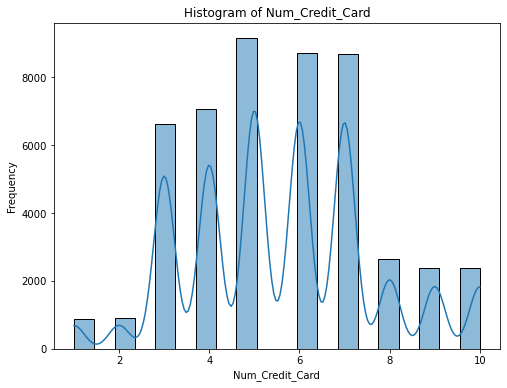

In [32]:
# Num_Credit_Card analysis after cleanup
generate_boxplot(train_df1, 'Num_Credit_Card')
generate_histogram(train_df1, 'Num_Credit_Card')
# generate_bar_chart(train_df1, 'Num_Credit_Card')


In [33]:
train_df1.shape

(49491, 22)

## Interest_Rate Column Data Analysis  

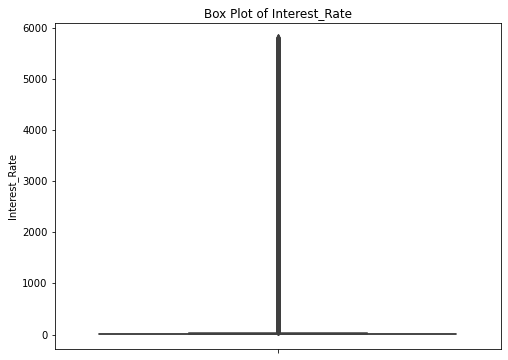

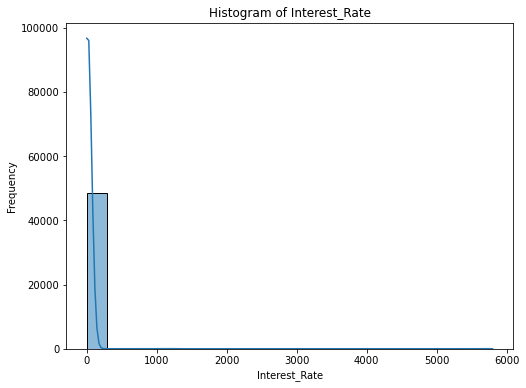

In [34]:
# Interest_Rate analysis
generate_boxplot(train_df1, 'Interest_Rate')
generate_histogram(train_df1, 'Interest_Rate')
# generate_bar_chart(train_df1, 'Interest_Rate')


Generally, Interest_Rate should be a % and it should be always 0 to 100. But normally Interest_Rate can be very high value such as 80%. The data that appears to be impractical will be excluded.

In [35]:
train_df1 = train_df1[(train_df1['Interest_Rate'] >= 1) & (train_df1['Interest_Rate'] < 40)]

train_df1.shape

(48462, 22)

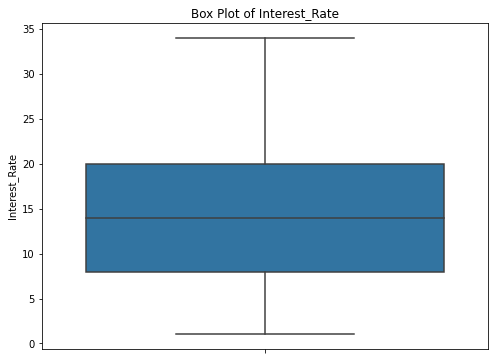

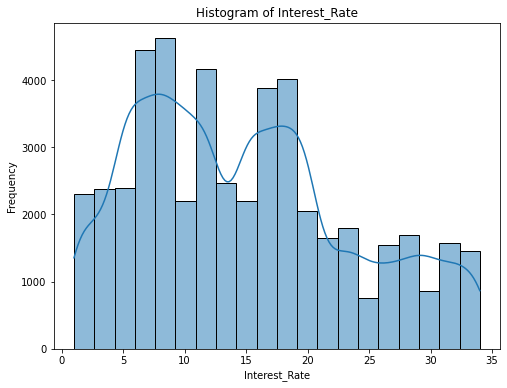

In [36]:
# Interest_Rate analysis after cleanup
generate_boxplot(train_df1, 'Interest_Rate')
generate_histogram(train_df1, 'Interest_Rate')
# generate_bar_chart(train_df1, 'Interest_Rate')


## Num_of_Loan Column Data Analysis  

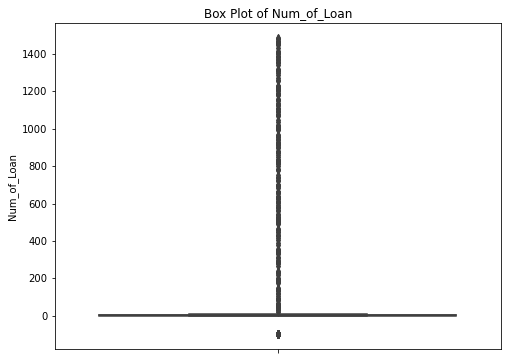

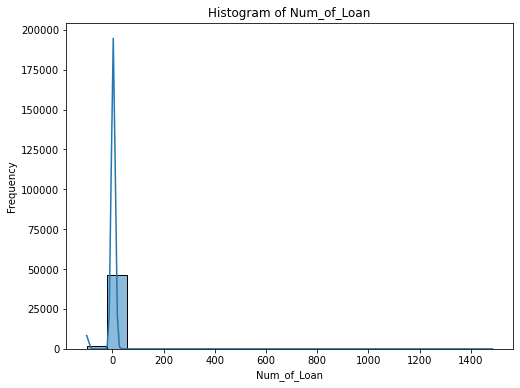

In [37]:
# Num_of_Loan analysis
generate_boxplot(train_df1, 'Num_of_Loan')
generate_histogram(train_df1, 'Num_of_Loan')
# generate_bar_chart(train_df1, 'Num_of_Loan')


Above Num_of_Loan is not appearing to be realistic practically in real world. So, those outliers should be excluded.

In [38]:
train_df1 = train_df1[(train_df1['Num_of_Loan'] >= 1) & (train_df1['Num_of_Loan'] < 15)]

train_df1.shape

(41170, 22)

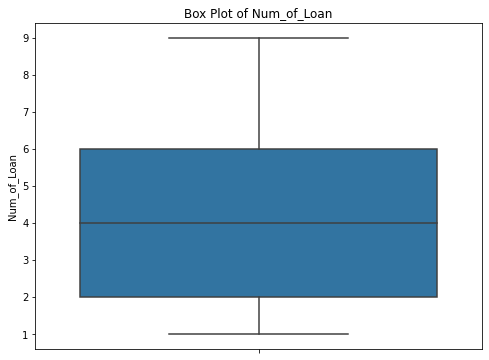

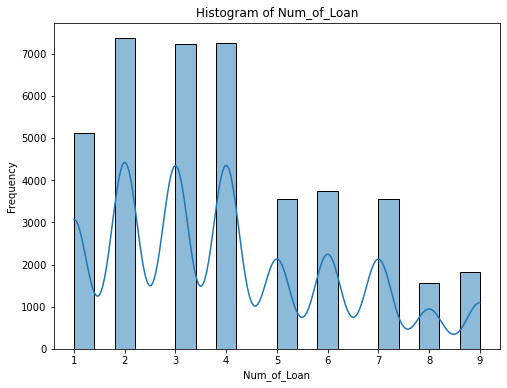

In [39]:
# Num_of_Loan analysis after outlier removal 
generate_boxplot(train_df1, 'Num_of_Loan')
generate_histogram(train_df1, 'Num_of_Loan')
# generate_bar_chart(train_df1, 'Num_of_Loan')

In [40]:
train_df1.shape

(41170, 22)

## Delay_from_due_date Column Data Analysis  

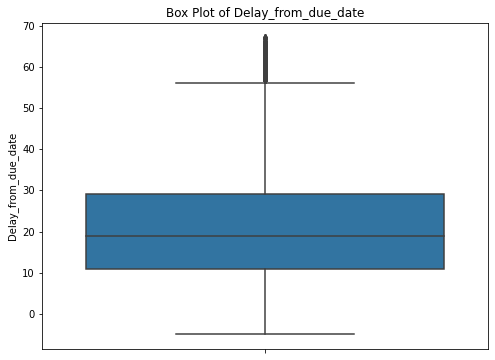

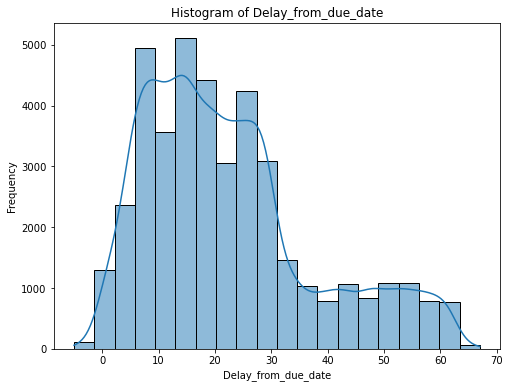

In [41]:
# Delay_from_due_date analysis
generate_boxplot(train_df1, 'Delay_from_due_date')
generate_histogram(train_df1, 'Delay_from_due_date')
# generate_bar_chart(train_df1, 'Delay_from_due_date')


Seems there are few outliers in the Delay_from_due_date data. So, they will be excluded.

In [42]:
train_df1 = train_df1[(train_df1['Delay_from_due_date'] >= -10) & (train_df1['Delay_from_due_date'] < 60)]

train_df1.shape

(40329, 22)

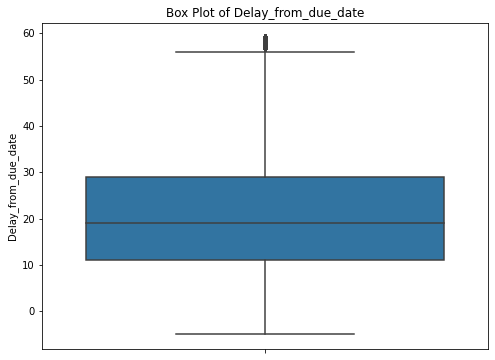

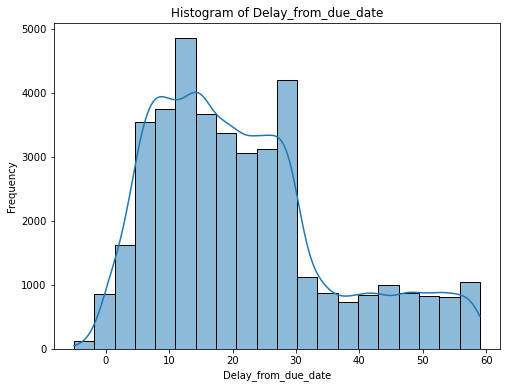

In [43]:
# Delay_from_due_date analysis after cleanup
generate_boxplot(train_df1, 'Delay_from_due_date')
generate_histogram(train_df1, 'Delay_from_due_date')
# generate_bar_chart(train_df1, 'Delay_from_due_date')


## Num_of_Delayed_Payment Column Data Analysis  

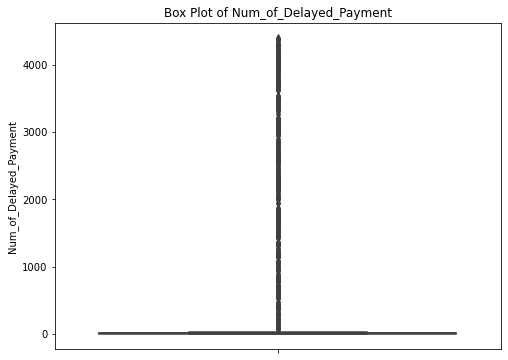

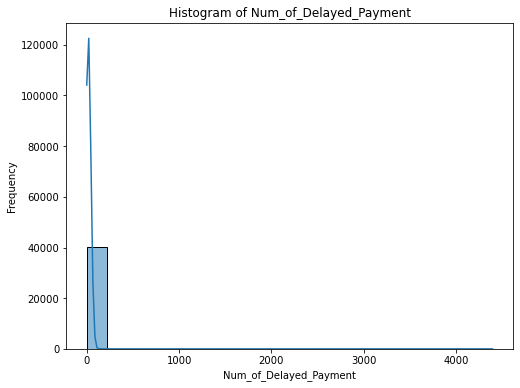

In [44]:
# Num_of_Delayed_Payment analysis
generate_boxplot(train_df1, 'Num_of_Delayed_Payment')
generate_histogram(train_df1, 'Num_of_Delayed_Payment')
# generate_bar_chart(train_df1, 'Num_of_Delayed_Payment')

Num_of_Delayed_Payment count is having impractical data as it appears to be. So, those anomalies will be excluded.

In [45]:
train_df1 = train_df1[(train_df1['Num_of_Delayed_Payment'] >= -4) & (train_df1['Num_of_Delayed_Payment'] < 72)]

In [46]:
train_df1.shape

(40008, 22)

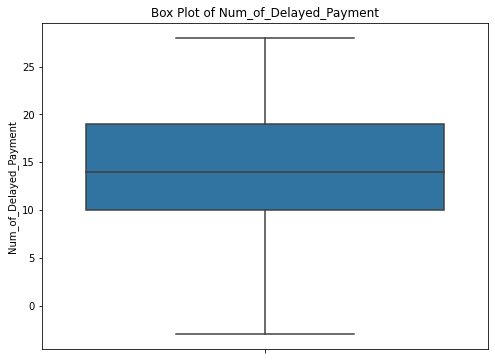

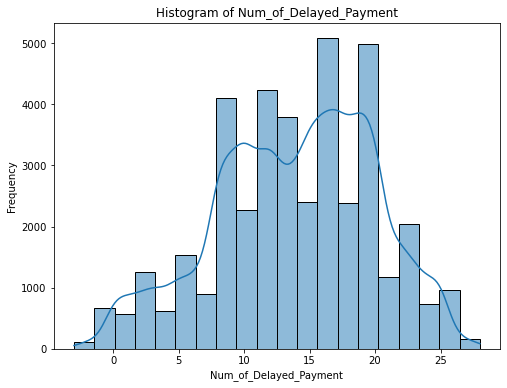

In [47]:
# Num_of_Delayed_Payment analysis after cleanup
generate_boxplot(train_df1, 'Num_of_Delayed_Payment')
generate_histogram(train_df1, 'Num_of_Delayed_Payment')
# generate_bar_chart(train_df1, 'Num_of_Delayed_Payment')

## Changed_Credit_Limit Column Data Analysis  

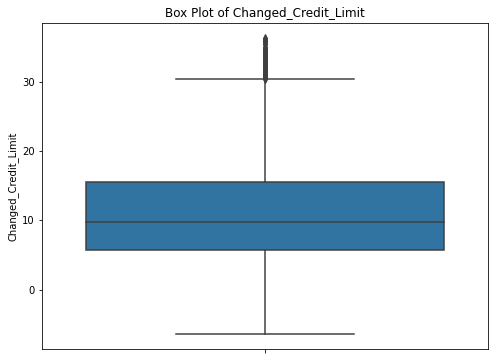

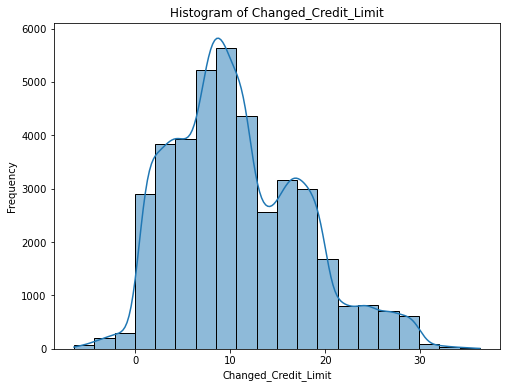

In [48]:
# Changed_Credit_Limit analysis
generate_boxplot(train_df1, 'Changed_Credit_Limit')
generate_histogram(train_df1, 'Changed_Credit_Limit')
# generate_bar_chart(train_df1, 'Changed_Credit_Limit')

Changed_Credit_Limit having a practical data distribution.

## Outstanding_Debt Column Data Analysis  

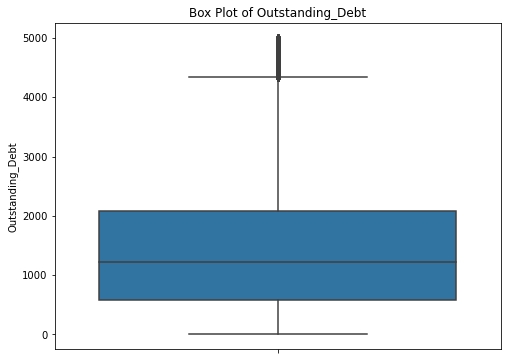

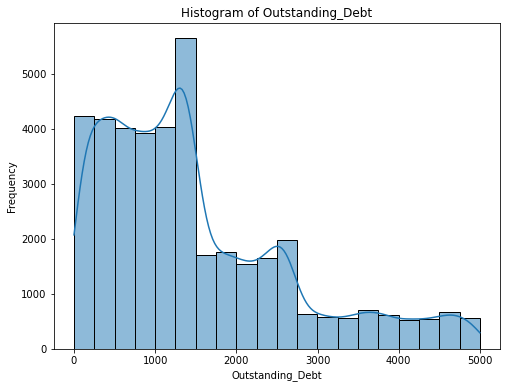

In [49]:
# Outstanding_Debt analysis
generate_boxplot(train_df1, 'Outstanding_Debt')
generate_histogram(train_df1, 'Outstanding_Debt')
# generate_bar_chart(train_df1, 'Outstanding_Debt')

Outstanding_Debt having a practical data distribution.

## Credit_Utilization_Ratio Column Data Analysis  

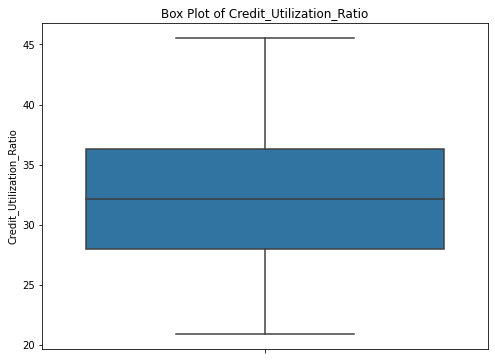

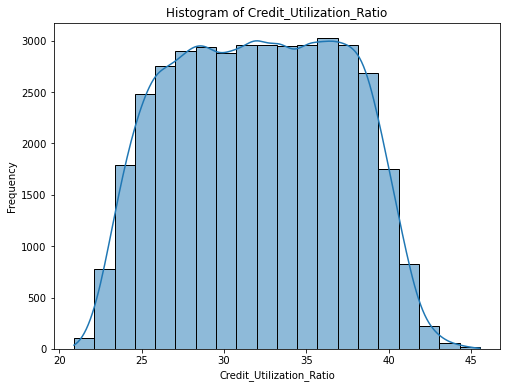

In [50]:
# Credit_Utilization_Ratio analysis after cleanup
generate_boxplot(train_df1, 'Credit_Utilization_Ratio')
generate_histogram(train_df1, 'Credit_Utilization_Ratio')
# generate_bar_chart(train_df1, 'Credit_Utilization_Ratio')

Credit_Utilization_Ratio having a practical data distribution.

## Total_EMI_per_month Column Data Analysis  

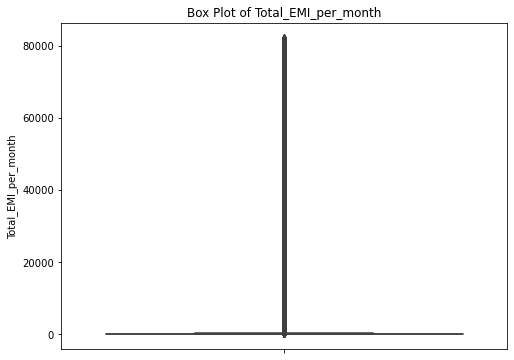

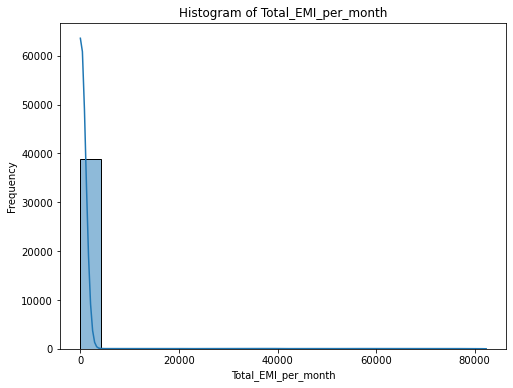

In [51]:
# Total_EMI_per_month analysis
generate_boxplot(train_df1, 'Total_EMI_per_month')
generate_histogram(train_df1, 'Total_EMI_per_month')
# generate_bar_chart(train_df1, 'Total_EMI_per_month')

As per the box plot, seems Total_EMI_per_month is having outliers and those will be excluded.

In [52]:
train_df1['Total_EMI_per_month'].value_counts().sort_index()

4.462837        7
4.713184        5
4.865690        5
4.916139        3
5.138485        4
               ..
82122.000000    1
82193.000000    1
82204.000000    1
82236.000000    1
82331.000000    1
Name: Total_EMI_per_month, Length: 10540, dtype: int64

In [53]:
# Remove Total_EMI_per_month > 350  

train_df1 = train_df1[(train_df1['Total_EMI_per_month'] >= 0) & (train_df1['Total_EMI_per_month'] < 350)]                       
                      

In [54]:
train_df1.shape

(37522, 22)

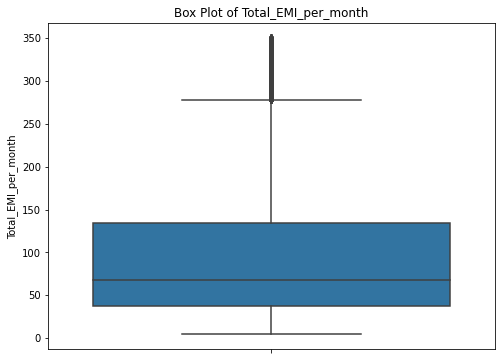

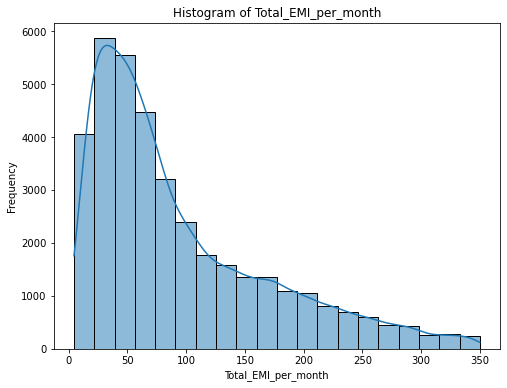

In [55]:
# Total_EMI_per_month analysis after cleanup
generate_boxplot(train_df1, 'Total_EMI_per_month')
generate_histogram(train_df1, 'Total_EMI_per_month')
# generate_bar_chart(train_df1, 'Total_EMI_per_month')

## Amount_invested_monthly Column Data Analysis  

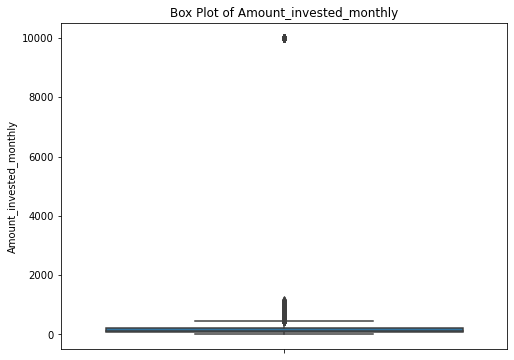

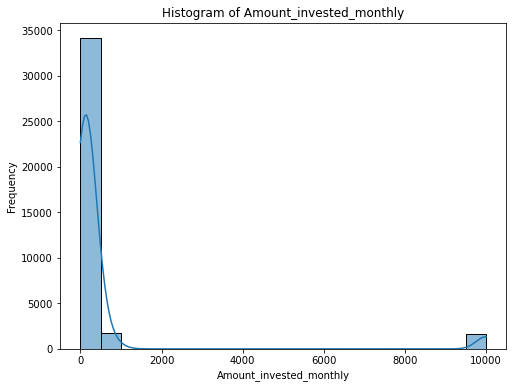

In [56]:
# Amount_invested_monthly analysis
generate_boxplot(train_df1, 'Amount_invested_monthly')
generate_histogram(train_df1, 'Amount_invested_monthly')
# generate_bar_chart(train_df1, 'Amount_invested_monthly')

It appears to be that there are outliers according to the boxplot, as there is no any instance from 2000 to nearly 9000. So, the outliers will be excluded and the data will be taken within the range of 0 to 500 to be more practical.

In [57]:
train_df1 = train_df1[(train_df1['Amount_invested_monthly'] >= 0) & (train_df1['Amount_invested_monthly'] < 500)]

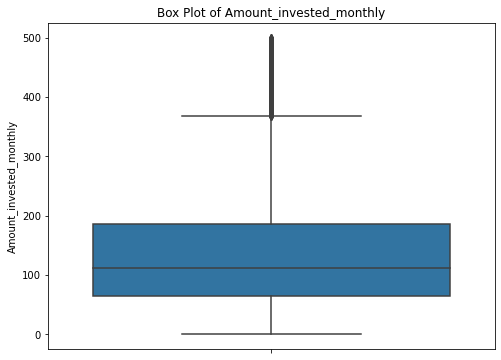

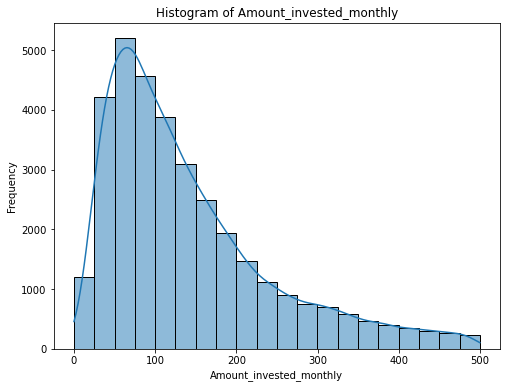

In [58]:
# Amount_invested_monthly analysis after cleanup
generate_boxplot(train_df1, 'Amount_invested_monthly')
generate_histogram(train_df1, 'Amount_invested_monthly')
# generate_bar_chart(train_df1, 'Amount_invested_monthly')

## Monthly_Balance Column Data Analysis  

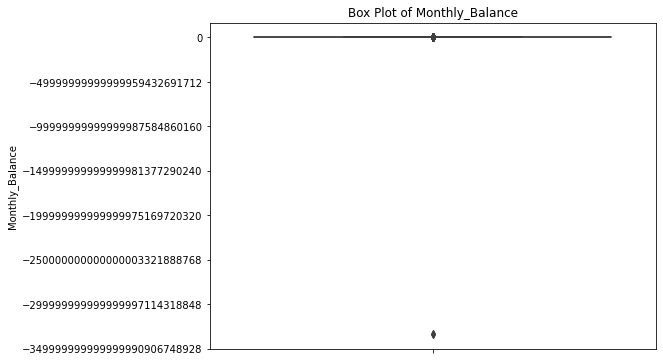

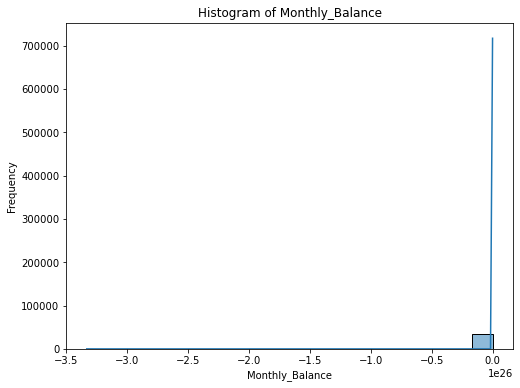

In [59]:
# Monthly_Balance analysis
generate_boxplot(train_df1, 'Monthly_Balance')
generate_histogram(train_df1, 'Monthly_Balance')
# generate_bar_chart(train_df1, 'Monthly_Balance')

Seems Monthly_Balance is having huge negative values as well as huge positive values so those data will be excluded.

In [60]:
train_df1 = train_df1[(train_df1['Monthly_Balance'] >= 0) & (train_df1['Monthly_Balance'] < 700)]

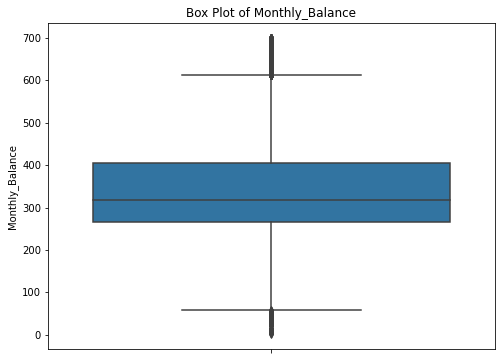

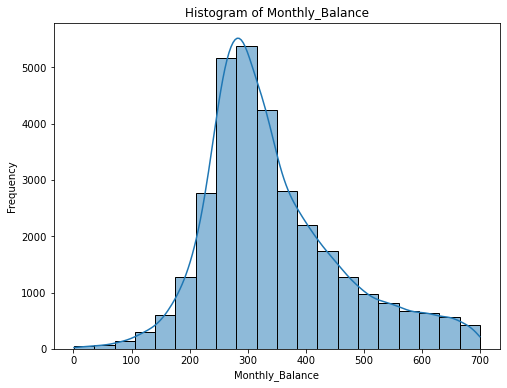

In [61]:
# Monthly_Balance analysis after cleanup
generate_boxplot(train_df1, 'Monthly_Balance')
generate_histogram(train_df1, 'Monthly_Balance')
# generate_bar_chart(train_df1, 'Monthly_Balance')

In [62]:
file_path = 'df_clean.csv'
train_df1.to_csv(file_path, index=False)

In [63]:
train_df1.shape

(32065, 22)

# Feature Correlations with the Target Variable

In [64]:
df = train_df1

### ANOVA p-values Verification 
#### This test will help to understand correlataions or any relations with Numerical Columns and Credit_Score (Catagorical) 

In [65]:
# List of numerical columns (excluding 'Credit_Score')
numerical_columns = df.select_dtypes(include=['int32', 'int64', 'float64']).columns.tolist()

In [66]:
numerical_columns

['Age',
 'Annual_Income',
 'Monthly_Inhand_Salary',
 'Num_Bank_Accounts',
 'Num_Credit_Card',
 'Interest_Rate',
 'Num_of_Loan',
 'Delay_from_due_date',
 'Num_of_Delayed_Payment',
 'Changed_Credit_Limit',
 'Outstanding_Debt',
 'Credit_Utilization_Ratio',
 'Total_EMI_per_month',
 'Amount_invested_monthly',
 'Monthly_Balance']

In [67]:
# Perform ANOVA for each numerical feature
p_values = {}
for col in numerical_columns:
    groups = [df[df['Credit_Score'] == val][col] for val in df['Credit_Score'].unique()]
    f_statistic, p_value = f_oneway(*groups)
    p_values[col] = p_value

In [68]:
# Display p-values
print("ANOVA p-values:")
for col, p_value in p_values.items():
    print(f"{col}: {p_value:.4f}")

ANOVA p-values:
Age: 0.0000
Annual_Income: 0.0000
Monthly_Inhand_Salary: 0.0000
Num_Bank_Accounts: 0.0000
Num_Credit_Card: 0.0000
Interest_Rate: 0.0000
Num_of_Loan: 0.0000
Delay_from_due_date: 0.0000
Num_of_Delayed_Payment: 0.0000
Changed_Credit_Limit: 0.0000
Outstanding_Debt: 0.0000
Credit_Utilization_Ratio: 0.0838
Total_EMI_per_month: 0.0000
Amount_invested_monthly: 0.0000
Monthly_Balance: 0.0000


In [69]:
# Convert the correlation and ANOVA results to DataFrames for plotting
corr_df = pd.DataFrame(p_values.items(), columns=['Feature', 'Correlation'])
anova_df = pd.DataFrame(p_values.items(), columns=['Feature', 'ANOVA_P_Value'])

In [70]:
corr_df

,Feature,Correlation
0,Age,4.903622e-149
1,Annual_Income,1.818063e-86
2,Monthly_Inhand_Salary,8.232974e-84
3,Num_Bank_Accounts,0.000000e+00
4,Num_Credit_Card,0.000000e+00
5,Interest_Rate,0.000000e+00
6,Num_of_Loan,0.000000e+00
7,Delay_from_due_date,0.000000e+00
8,Num_of_Delayed_Payment,0.000000e+00
9,Changed_Credit_Limit,1.454099e-318


In [71]:
anova_df

,Feature,ANOVA_P_Value
0,Age,4.903622e-149
1,Annual_Income,1.818063e-86
2,Monthly_Inhand_Salary,8.232974e-84
3,Num_Bank_Accounts,0.000000e+00
4,Num_Credit_Card,0.000000e+00
5,Interest_Rate,0.000000e+00
6,Num_of_Loan,0.000000e+00
7,Delay_from_due_date,0.000000e+00
8,Num_of_Delayed_Payment,0.000000e+00
9,Changed_Credit_Limit,1.454099e-318


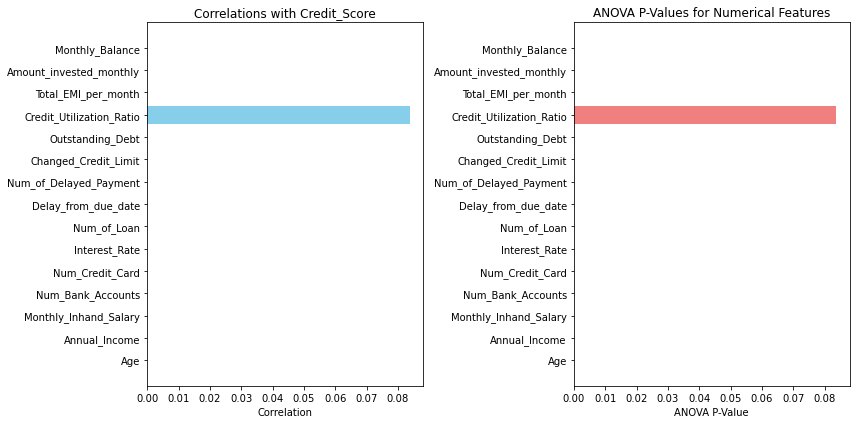

In [72]:
# Create subplots for correlation and ANOVA p-value bar charts
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Bar chart for correlations
axes[0].barh(corr_df['Feature'], corr_df['Correlation'], color='skyblue')
axes[0].set_xlabel('Correlation')
axes[0].set_title('Correlations with Credit_Score')

# Bar chart for ANOVA p-values
axes[1].barh(anova_df['Feature'], anova_df['ANOVA_P_Value'], color='lightcoral')
axes[1].set_xlabel('ANOVA P-Value')
axes[1].set_title('ANOVA P-Values for Numerical Features')

plt.tight_layout()
plt.show()

#### It is possible to consider that column to be a correlated column if the P-Value is less than 0.05 (5%). As a result, all columns appear to be related to the credit score, apart from Credit_Utilization_Ratio.

### Chi-Square p-values Verification 
#### This test will help to understand correlataions or any relations with Categoricle Columns and Credit_Score (Catagorical) 

In [73]:
# List of categorical columns (excluding 'Credit_Score')
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
categorical_columns.remove('Credit_Score')


In [74]:
# Perform chi-squared test for each categorical feature
chi2_results = {}
for col in categorical_columns:
    # Create a contingency table
    contingency_table = pd.crosstab(df[col], df['Credit_Score'])
    chi2, p_value, _, _ = chi2_contingency(contingency_table)
    chi2_results[col] = {'Chi-Square': chi2, 'p-value': p_value}

In [75]:
# Display chi-squared test results
print("Chi-Squared Test Results:")
for col, results in chi2_results.items():
    print(f"{col}:")
    print(f"  Chi-Square: {results['Chi-Square']:.4f}")
    print(f"  p-value: {results['p-value']:.4f}")

Chi-Squared Test Results:
Occupation:
  Chi-Square: 76.6993
  p-value: 0.0000
Type_of_Loan:
  Chi-Square: 27571.7753
  p-value: 0.0000
Credit_Mix:
  Chi-Square: 10531.7895
  p-value: 0.0000
Credit_History_Age:
  Chi-Square: 6687.7563
  p-value: 0.0000
Payment_of_Min_Amount:
  Chi-Square: 6710.6645
  p-value: 0.0000
Payment_Behaviour:
  Chi-Square: 405.5424
  p-value: 0.0000


In [76]:
# Convert chi2_results to a DataFrame for easier plotting
chi2_df = pd.DataFrame(chi2_results).T

In [77]:
chi2_df

,Chi-Square,p-value
Occupation,76.699306,2.048905e-06
Type_of_Loan,27571.775320,0.000000e+00
Credit_Mix,10531.789546,0.000000e+00
Credit_History_Age,6687.756257,0.000000e+00
Payment_of_Min_Amount,6710.664506,0.000000e+00
Payment_Behaviour,405.542424,6.223072e-81


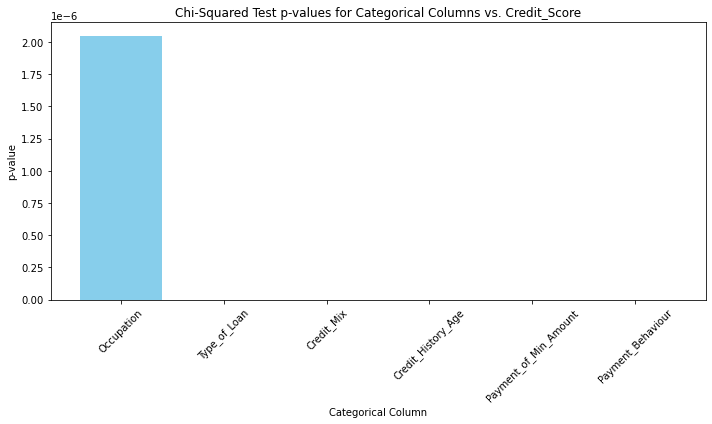

In [78]:
# Create a bar chart for p-values
plt.figure(figsize=(10, 6))
plt.bar(chi2_df.index, chi2_df['p-value'], color='skyblue')
plt.xlabel('Categorical Column')
plt.ylabel('p-value')
plt.title('Chi-Squared Test p-values for Categorical Columns vs. Credit_Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### It is possible to consider a column to be a correlated column if the P-Value is less than 0.05 (5%). Each of the categorical columns (Occupation, Type of Loan, Credit Mix, Credit History Age, Payment of Minimum Amount, Payment Behavior) has a substantial correlation with the dependent categorical variable "Credit Score," as shown by the fact that all p-values are very close to 0



# Feature Selection

In [79]:
# Acording to the ANNOVA P-Value test, remove Total_EMI_per_month column 
train_df1 = train_df1.drop('Credit_Utilization_Ratio', axis=1)

In [80]:
# Acording to the Chi-Squair P-Value test, remove Occupation column 
# train_df1 = train_df1.drop('Occupation', axis=1)

In [81]:
train_df1.dtypes

Age                          int64
Occupation                  object
Annual_Income              float64
Monthly_Inhand_Salary      float64
Num_Bank_Accounts            int64
Num_Credit_Card              int64
Interest_Rate                int64
Num_of_Loan                  int32
Type_of_Loan                object
Delay_from_due_date          int64
Num_of_Delayed_Payment     float64
Changed_Credit_Limit       float64
Credit_Mix                  object
Outstanding_Debt           float64
Credit_History_Age          object
Payment_of_Min_Amount       object
Total_EMI_per_month        float64
Amount_invested_monthly    float64
Payment_Behaviour           object
Monthly_Balance            float64
Credit_Score                object
dtype: object

### Decouple indemendet & dependent variables in to two sets 

In [82]:
df_indi = train_df1.drop(['Credit_Score'], axis = 1)
df_depend = train_df1['Credit_Score']

In [83]:
df_depend

0            Good
6            Good
8        Standard
9            Good
12           Good
           ...   
99991    Standard
99994        Poor
99995        Poor
99996        Poor
99999        Poor
Name: Credit_Score, Length: 32065, dtype: object

# Data Normalization & Categorical Encoding   

#### We are following 2 steps. 1st, will do the normalizaton for the numerical fields using MinMaxScaler(). and as the 2nd step will do the Categorical Encording. 

#### To do this, need to extract numerical and categorical columns in to two sets.  

In [84]:
# Normalize numerical columns using Min-Max scaling (scaling to the range [0, 1])
numerical_columns = df_indi.select_dtypes(include=['number']).columns.tolist()
categorical_columns = df_indi.select_dtypes(include=['object']).columns.tolist()


In [85]:
numerical_scaler = MinMaxScaler()

In [86]:
df_indi[numerical_columns] = numerical_scaler.fit_transform(df_indi[numerical_columns])

In [87]:
# Encode categorical variables 
label_encoders = {}
for col in categorical_columns:
    label_encoder = LabelEncoder()
    df_indi[col] = label_encoder.fit_transform(df_indi[col])
    label_encoders[col] = label_encoder

In [88]:
df_indi

,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Credit_Mix,Outstanding_Debt,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance
0,0.083333,12,0.098459,0.143959,0.222222,0.333333,0.060606,0.375,99,0.125000,0.322581,0.414600,2,0.161968,179,1,0.130615,0.160918,2,0.445912
6,0.083333,12,0.098459,0.143959,0.222222,0.333333,0.060606,0.375,99,0.125000,0.354839,0.414600,1,0.161968,187,1,0.130615,0.356881,5,0.348702
8,0.222222,7,0.226400,0.258765,0.111111,0.333333,0.151515,0.000,530,0.125000,0.225806,0.277726,1,0.120958,235,1,0.041558,0.208697,5,0.672302
9,0.222222,13,0.226400,0.258765,0.111111,0.333333,0.151515,0.000,530,0.187500,0.129032,0.324520,1,0.120958,236,1,0.041558,0.080826,0,0.692194
12,0.222222,13,0.226400,0.258765,0.111111,0.333333,0.151515,0.000,530,0.125000,0.129032,0.301123,1,0.120958,229,1,0.041558,0.260372,5,0.635347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99991,0.250000,1,0.105686,0.153902,1.000000,0.777778,0.848485,0.500,3859,0.593750,0.903226,0.579317,0,0.714585,360,2,0.163593,0.069363,0,0.481501
99994,0.138889,9,0.265278,0.289184,0.333333,0.555556,0.181818,0.125,529,0.390625,0.290323,0.373187,2,0.100418,305,1,0.088717,0.281315,1,0.585816
99995,0.138889,9,0.265278,0.289184,0.333333,0.555556,0.181818,0.125,529,0.437500,0.322581,0.419981,2,0.100418,306,1,0.088717,0.122009,0,0.685433
99996,0.138889,9,0.265278,0.289184,0.333333,0.555556,0.181818,0.125,529,0.359375,0.322581,0.419981,2,0.100418,307,1,0.088717,0.108431,1,0.709454


## Modeling

In [89]:
# Split data frames in to training & test (70% 30%)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_indi,df_depend, test_size = 0.30, random_state = 100)

### Logistic Regression Model 

In [90]:
# Create and train a Logistic Regression model
LR_model = LogisticRegression(max_iter=7000)
LR_model.fit(X_train, y_train)

LogisticRegression(max_iter=7000)

In [91]:
# Make predictions on the test set
LR_y_pred = LR_model.predict(X_test)

In [92]:
LR_train_preds = LR_model.predict(X_train)
LR_train_preds

array(['Standard', 'Poor', 'Standard', ..., 'Good', 'Standard',
       'Standard'], dtype=object)

In [93]:
LR_test_preds = LR_model.predict(X_test)
LR_test_preds

array(['Standard', 'Standard', 'Standard', ..., 'Standard', 'Standard',
       'Standard'], dtype=object)

In [94]:
LR_train_preds_score = LR_model.score(X_train,y_train)
LR_train_preds_score

0.6453553129873023

In [95]:
LR_test_preds_score = LR_model.score(X_test,y_test)
LR_test_preds_score

0.6477130977130977

In [96]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, LR_y_pred)

In [97]:
# Create a DataFrame for the confusion matrix (optional)
confusion_df = pd.DataFrame(conf_matrix, index=LR_model.classes_, columns=LR_model.classes_)


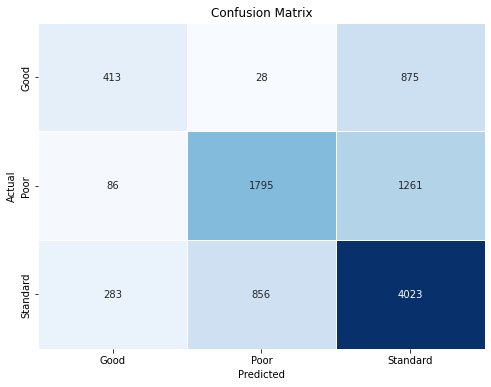

In [98]:
# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues', linewidths=.5, cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [99]:
# Evaluate the model
accuracy = accuracy_score(y_test, LR_y_pred)
classification_rep = classification_report(y_test, LR_y_pred)
confusion_mat = confusion_matrix(y_test, LR_y_pred)

In [100]:
# Print the results
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_rep)
print("Confusion Matrix:\n", confusion_mat)

Accuracy: 0.6477130977130977
Classification Report:
               precision    recall  f1-score   support

        Good       0.53      0.31      0.39      1316
        Poor       0.67      0.57      0.62      3142
    Standard       0.65      0.78      0.71      5162

    accuracy                           0.65      9620
   macro avg       0.62      0.55      0.57      9620
weighted avg       0.64      0.65      0.64      9620

Confusion Matrix:
 [[ 413   28  875]
 [  86 1795 1261]
 [ 283  856 4023]]


### Random Forest Classifier Model 

In [101]:
# Create and train a Random Forest Classifier model
RFC_model = RandomForestClassifier()
RFC_model.fit(X_train, y_train)

RandomForestClassifier()

In [102]:
# Make predictions on the test set
RFC_y_pred =RFC_model.predict(X_test)

In [103]:
RFC_train_preds = RFC_model.predict(X_train)
RFC_train_preds

array(['Standard', 'Standard', 'Poor', ..., 'Good', 'Standard', 'Good'],
      dtype=object)

In [104]:
RFC_test_preds = RFC_model.predict(X_test)
RFC_test_preds

array(['Standard', 'Standard', 'Good', ..., 'Poor', 'Standard', 'Good'],
      dtype=object)

In [105]:
RFC_train_preds_score = RFC_model.score(X_train,y_train)
RFC_train_preds_score

1.0

In [106]:
RFC_test_preds_score = RFC_model.score(X_test,y_test)
RFC_test_preds_score

0.7903326403326403

In [107]:
# Compute the confusion matrix
conf_matrix_rfc = confusion_matrix(y_test, RFC_y_pred)

In [108]:
# Create a DataFrame for the confusion matrix (optional)
confusion_df_rfc = pd.DataFrame(conf_matrix_rfc, index=RFC_model.classes_, columns=RFC_model.classes_)


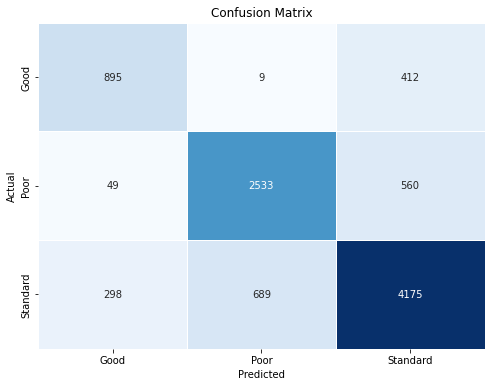

In [109]:
# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df_rfc, annot=True, fmt='d', cmap='Blues', linewidths=.5, cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [110]:
# Evaluate the model
accuracy_rfc = accuracy_score(y_test, RFC_y_pred)
classification_rep_rfc = classification_report(y_test, RFC_y_pred)
confusion_mat_rfc = confusion_matrix(y_test, RFC_y_pred)


In [111]:
# Print the results
print(f"Accuracy: {accuracy_rfc:.2f}")
print("Classification Report:\n", classification_rep_rfc)
print("Confusion Matrix:\n", confusion_mat_rfc)

Accuracy: 0.79
Classification Report:
               precision    recall  f1-score   support

        Good       0.72      0.68      0.70      1316
        Poor       0.78      0.81      0.79      3142
    Standard       0.81      0.81      0.81      5162

    accuracy                           0.79      9620
   macro avg       0.77      0.77      0.77      9620
weighted avg       0.79      0.79      0.79      9620

Confusion Matrix:
 [[ 895    9  412]
 [  49 2533  560]
 [ 298  689 4175]]
